# Stylometric Signature Extraction

#### Ogni feature non misura cosa viene detto, ma come il testo emerge nel tempo: <br> ritmo, distribuzione, regolarità e micro-variazioni. <br> I modelli generativi producono firme statistiche stabili anche quando il contenuto cambia.

In [9]:
!python -m spacy download en_core_web_sm

Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\errors.py", line 3, in <module>
    from .compat import Literal
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\compat.py", line 5, in <module>
    from thinc.util import copy_array
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\thinc\__init__.py", line 5, in <module>
    from .config import registry
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\thinc\config.py", line 5, in <module>
    from .types import Decorator
  File "c:\Use

In [10]:
#!pip install textstat

In [11]:
import pandas as pd

In [12]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from itertools import tee
from textblob import TextBlob
from textstat import flesch_reading_ease
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import spacy
# Carica il modello una sola volta fuori dalla funzione
nlp = spacy.load("en_core_web_sm", disable=["ner"])

def extract_stylometric_signature(text):
    # IMPORTANTE: Passa il testo ORIGINALE, non quello già pulito dal primo notebook
    doc = nlp(text) 
    
    features = {}
    features.update(rhythmic_features(doc))
    features.update(syntactic_features(doc))
    # ... tutte le altre feature che hai nel file signature.ipynb
    return pd.Series(features)

In [14]:
# Carica modello spaCy (disabilita NER per velocità)
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# Carica dataset pulito
df_clean = pd.read_csv('ai_human_clean.csv')
print(f" Dataset caricato: {df_clean.shape[0]} righe, {df_clean.shape[1]} colonne\n")

 Dataset caricato: 500 righe, 50 colonne



## Utility functions

In [15]:
def pairwise(iterable):
    """Genera coppie consecutive: s -> (s0,s1), (s1,s2), (s2,s3), ..."""
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def sentence_lengths(doc):
    """Estrae lunghezze delle frasi"""
    return np.array([len(sent) for sent in doc.sents if len(sent) > 0])


def coefficient_of_variation(x):
    """CV = std/mean - misura variabilità relativa"""
    mu = np.mean(x)
    return np.std(x) / mu if mu > 0 else 0.0


def burstiness_index(x):
    """Burstiness = (σ - μ) / (σ + μ) - irregolarità temporale"""
    mu, sigma = np.mean(x), np.std(x)
    return (sigma - mu) / (sigma + mu) if (sigma + mu) > 0 else 0.0


def safe_entropy(counter: Counter) -> float:
    """Calcola entropia evitando divisioni per zero"""
    values = np.array(list(counter.values()), dtype=float)
    if values.sum() == 0:
        return 0.0
    probs = values / values.sum()
    return entropy(probs)


## R — Rhythmic Control

In [16]:
def rhythmic_features(doc):
    """Firma del ritmo: variabilità lunghezza frasi"""
    lengths = sentence_lengths(doc)
    if len(lengths) == 0:
        return {"sentence_length_cv": 0.0, "burstiness_index": 0.0}
    
    return {
        "sentence_length_cv": coefficient_of_variation(lengths),
        "burstiness_index": burstiness_index(lengths)
    }

## S — Syntactic Entropy

In [17]:
def pos_bigram_entropy(doc):
    """Entropia delle transizioni POS (Part-of-Speech)"""
    pos_tags = [token.pos_ for token in doc]
    if len(pos_tags) < 2:
        return 0.0
    
    bigrams = list(pairwise(pos_tags))
    counts = Counter(bigrams)
    return safe_entropy(counts)


def dependency_depth_mean(doc):
    """Profondità media albero sintattico"""
    depths = []
    for sent in doc.sents:
        for token in sent:
            depth, current = 0, token
            while current.head != current:
                depth += 1
                current = current.head
            depths.append(depth)
    return np.mean(depths) if depths else 0.0


def syntactic_features(doc):
    """Firma sintattica: complessità strutturale"""
    return {
        "pos_bigram_entropy": pos_bigram_entropy(doc),
        "dependency_depth_mean": dependency_depth_mean(doc)
    }

## L — Lexical Efficiency

In [18]:
def lexical_features(doc):
    """Firma lessicale: efficienza comunicativa"""
    tokens = [t for t in doc if t.is_alpha]
    if not tokens:
        return {"lexical_compression_ratio": 0.0, "function_word_ratio": 0.0}
    
    lemmas = [t.lemma_ for t in tokens]
    function_words = [t for t in tokens if t.pos_ in {"DET", "ADP", "AUX", "PRON", "CCONJ", "SCONJ"}]

    return {
        "lexical_compression_ratio": len(set(lemmas)) / len(tokens),
        "function_word_ratio": len(function_words) / len(tokens)
    }

## D — Discourse Regularization


In [19]:
def sentence_similarity_drift(doc):
    """Drift semantico tra frasi consecutive"""
    sentences = [sent.text for sent in doc.sents]
    if len(sentences) < 2:
        return 0.0

    vectors = np.array([nlp(sent).vector for sent in sentences])
    sims = [cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
            for i in range(len(vectors) - 1)]
    return float(np.mean(sims))


def structural_redundancy(doc):
    """Ridondanza pattern sintattici"""
    patterns = []
    for sent in doc.sents:
        pattern = tuple(tok.dep_ for tok in sent)
        patterns.append(pattern)
    
    if not patterns:
        return 0.0
    
    counts = Counter(patterns)
    repeated = sum(c for c in counts.values() if c > 1)
    return repeated / len(patterns)


def discourse_features(doc):
    """Firma del discorso: coesione e ridondanza"""
    return {
        "sentence_similarity_drift": sentence_similarity_drift(doc),
        "structural_redundancy": structural_redundancy(doc)
    }

## E — Emotional Variance

In [20]:
def fast_sentiment(text):
    """Sentiment rapido con TextBlob"""
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0.0


def emotional_features(doc):
    """Firma emotiva: varianza polarità"""
    sentiments = []
    for sent in doc.sents:
        score = fast_sentiment(sent.text)
        sentiments.append(score)
    
    return {"sentiment_variance": np.std(sentiments) if sentiments else 0.0}


## C — Cognitive Load Distribution

In [21]:
def cognitive_features(doc):
    """Firma cognitiva: complessità lettura"""
    readability = []
    for sent in doc.sents:
        try:
            score = flesch_reading_ease(sent.text)
            readability.append(score)
        except:
            pass
    
    sub_clauses = sum(1 for tok in doc if tok.dep_ in {"advcl", "ccomp", "xcomp", "relcl"})
    sentences = len(list(doc.sents))

    return {
        "readability_oscillation": np.std(readability) if readability else 0.0,
        "clause_density": sub_clauses / sentences if sentences > 0 else 0.0
    }

## HAPAX & TEMPLATE 

In [22]:
def get_hapax_density(text):
    """Hapax Legomena Density - DNA dell'autore"""
    words = re.findall(r'\b\w+\b', str(text).lower())
    if not words:
        return 0.0
    
    word_counts = Counter(words)
    hapax_count = sum(1 for w in word_counts if word_counts[w] == 1)
    return hapax_count / len(words)


def get_template_bias(text):
    """Template Bias Score - La gabbia dell'IA"""
    score = 0.0
    text_lower = str(text).lower()
    
    # A. Liste puntate (molto comuni nell'IA)
    bullet_patterns = [r'^\s*[\-\*•]\s+', r'^\s*\d+[\.\)]\s+']
    if any(re.search(p, text, re.MULTILINE) for p in bullet_patterns):
        score += 1.5
    
    # B. Conclusioni "robotizzate"
    ai_conclusions = ['in conclusion', 'overall', 'to summarize', 
                      'it is important to note', 'in essence']
    if any(phrase in text_lower for phrase in ai_conclusions):
        score += 1.2
    
    # C. Connettivi iper-strutturati
    connectors = ['furthermore', 'moreover', 'additionally', 'consequently']
    connector_count = sum(1 for c in connectors if c in text_lower)
    if connector_count >= 2:
        score += 1.0
    
    return score

## function extraction

In [23]:
def extract_stylometric_signature(text):
    """
    Estrae la firma stilometrica completa (13 feature).
    Ottimizzata per velocità e robustezza.
    """
    try:
        # Limita lunghezza per performance
        text = str(text)[:10000]
        
        # Parsing spaCy
        doc = nlp(text)
        
        # Estrai tutte le feature
        features = {}
        features.update(rhythmic_features(doc))
        features.update(syntactic_features(doc))
        features.update(lexical_features(doc))
        features.update(discourse_features(doc))
        features.update(emotional_features(doc))
        features.update(cognitive_features(doc))
        
        # Feature avanzate (non richiedono doc spaCy)
        features['hapax_density'] = get_hapax_density(text)
        features['template_bias_score'] = get_template_bias(text)
        
        return pd.Series(features)
    
    except Exception as e:
        # Fallback: restituisci feature nulle
        print(f"Errore nell'elaborazione: {e}")
        return pd.Series({
            "sentence_length_cv": 0.0,
            "burstiness_index": 0.0,
            "pos_bigram_entropy": 0.0,
            "dependency_depth_mean": 0.0,
            "lexical_compression_ratio": 0.0,
            "function_word_ratio": 0.0,
            "sentence_similarity_drift": 0.0,
            "structural_redundancy": 0.0,
            "sentiment_variance": 0.0,
            "readability_oscillation": 0.0,
            "clause_density": 0.0,
            "hapax_density": 0.0,
            "template_bias_score": 0.0
        })

### APPLICAZIONE AL DATASET

In [24]:
print("\nEstrazione signature stilometriche...")
print("Questa operazione può richiedere 5-10 minuti...\n")

# Applica con progress bar
tqdm.pandas(desc="Processing texts")
signature_df = df_clean['text_cleaned'].progress_apply(extract_stylometric_signature)

print(f"\n Signature estratte: {signature_df.shape[1]} feature")
print(f"   Feature list: {', '.join(signature_df.columns)}\n")

# Merge con dataset originale
print("[Merge con dataset originale...")
df_final = pd.concat([df_clean, signature_df], axis=1)
print(f" Dataset finale: {df_final.shape[0]} righe, {df_final.shape[1]} colonne\n")




Estrazione signature stilometriche...
Questa operazione può richiedere 5-10 minuti...



Processing texts: 100%|██████████| 500/500 [00:11<00:00, 44.11it/s]


 Signature estratte: 13 feature
   Feature list: sentence_length_cv, burstiness_index, pos_bigram_entropy, dependency_depth_mean, lexical_compression_ratio, function_word_ratio, sentence_similarity_drift, structural_redundancy, sentiment_variance, readability_oscillation, clause_density, hapax_density, template_bias_score

[Merge con dataset originale...
 Dataset finale: 500 righe, 63 colonne



# VALIDAZIONE: CONFRONTO AI vs HUMAN

In [25]:
print("[5/6] Validazione: Confronto signature AI vs Human")
print("=" * 70)

# Calcolo aggregato
comparison = df_final.groupby('label_encoded')[signature_df.columns].agg(['mean', 'std'])

# Estrai solo le medie
means = comparison.xs('mean', axis=1, level=1)

print("\n MEDIE PER CLASSE:")
print(means.round(3).to_string())

# Differenza assoluta
if 1 in means.index and 0 in means.index:
    diff = means.loc[1] - means.loc[0]
    print("\n DIFFERENZA ASSOLUTA (AI - Human):")
    print(diff.sort_values(ascending=False).round(3).to_string())

    # Top 3 feature discriminanti
    top_discriminant = diff.abs().sort_values(ascending=False).head(3)
    print(f"\n TOP 3 FEATURE DISCRIMINANTI:")
    for feat, value in top_discriminant.items():
        direction = "più alta in AI" if diff[feat] > 0 else "più alta in Human"
        print(f"   • {feat}: Δ = {abs(value):.3f} ({direction})")


[5/6] Validazione: Confronto signature AI vs Human

 MEDIE PER CLASSE:
               sentence_length_cv  sentence_length_cv  burstiness_index  pos_bigram_entropy  dependency_depth_mean  lexical_compression_ratio  function_word_ratio  function_word_ratio  sentence_similarity_drift  structural_redundancy  sentiment_variance  readability_oscillation  clause_density  hapax_density  template_bias_score
label_encoded                                                                                                                                                                                                                                                                                                                             
0                           0.115               0.110            -0.838               2.568                  1.957                      0.964                0.139                0.361                      0.155                    0.0               0.051              


[6/6] Generazione visualizzazione...
✅ Visualizzazione salvata: 'signature_validation.png'



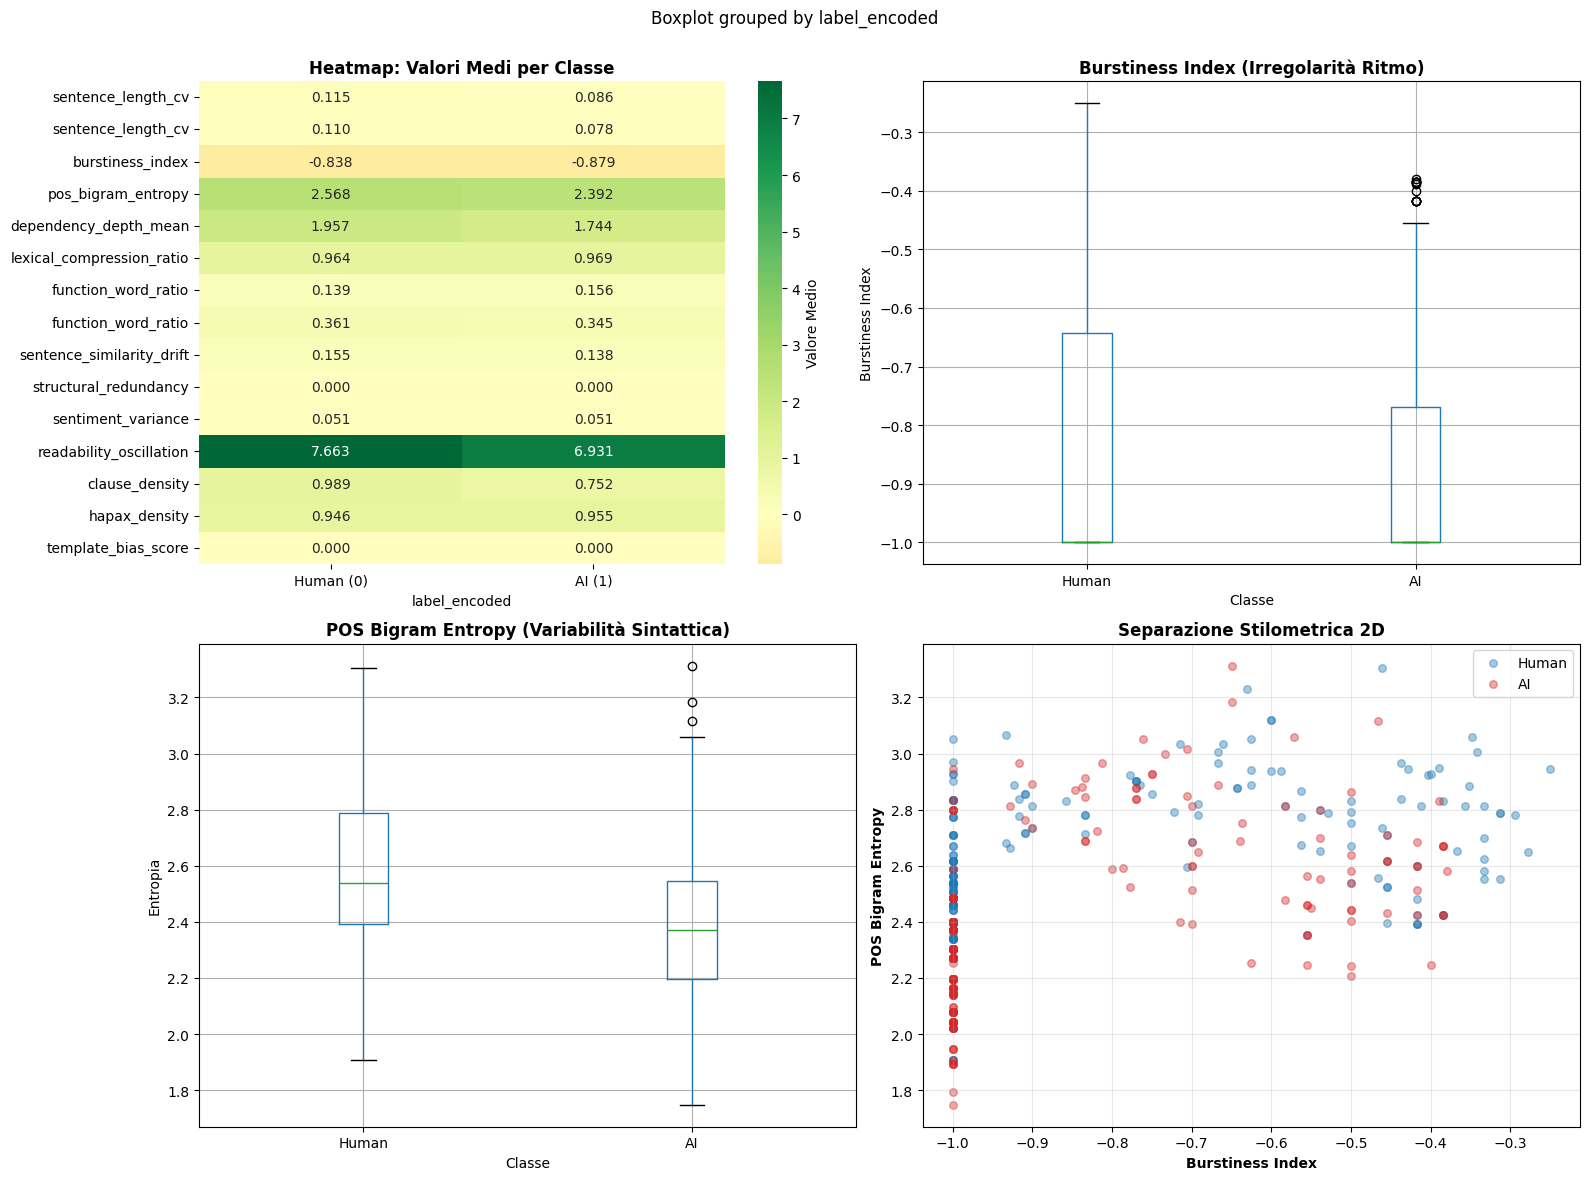

In [26]:
print("\n[6/6] Generazione visualizzazione...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Signature Stilometriche: Confronto AI vs Human', 
             fontsize=18, fontweight='bold')

# Plot 1: Heatmap comparativa
comparison_pivot = means.T
ax = axes[0, 0]
sns.heatmap(comparison_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0, ax=ax, cbar_kws={'label': 'Valore Medio'})
ax.set_title('Heatmap: Valori Medi per Classe', fontweight='bold')
ax.set_xticklabels(['Human (0)', 'AI (1)'])

# Plot 2: Distribuzione burstiness_index
ax = axes[0, 1]
df_final.boxplot(column='burstiness_index', by='label_encoded', ax=ax)
ax.set_title('Burstiness Index (Irregolarità Ritmo)', fontweight='bold')
ax.set_xlabel('Classe')
ax.set_ylabel('Burstiness Index')
ax.set_xticklabels(['Human', 'AI'])
plt.suptitle('')

# Plot 3: Distribuzione pos_bigram_entropy
ax = axes[1, 0]
df_final.boxplot(column='pos_bigram_entropy', by='label_encoded', ax=ax)
ax.set_title('POS Bigram Entropy (Variabilità Sintattica)', fontweight='bold')
ax.set_xlabel('Classe')
ax.set_ylabel('Entropia')
ax.set_xticklabels(['Human', 'AI'])

# Plot 4: Scatter 2D
ax = axes[1, 1]
for label, color in [(0, '#1f77b4'), (1, '#d62728')]:
    subset = df_final[df_final['label_encoded'] == label]
    label_name = 'Human' if label == 0 else 'AI'
    ax.scatter(subset['burstiness_index'], 
               subset['pos_bigram_entropy'],
               alpha=0.4, s=30, c=color, label=label_name)
ax.set_xlabel('Burstiness Index', fontweight='bold')
ax.set_ylabel('POS Bigram Entropy', fontweight='bold')
ax.set_title('Separazione Stilometrica 2D', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('signature_validation.png', dpi=300, bbox_inches='tight')
print("✅ Visualizzazione salvata: 'signature_validation.png'\n")


## SALVATAGGIO DATASET FINALE

In [27]:
output_file = 'ai_human_with_signatures.csv'
df_final.to_csv(output_file, index=False)

print("=" * 70)
print("✅ INTEGRAZIONE COMPLETATA CON SUCCESSO!")
print("=" * 70)
print(f"📁 File salvato: '{output_file}'")
print(f"📊 Dimensioni finali: {df_final.shape[0]} righe × {df_final.shape[1]} colonne")
print(f"🎯 Signature aggiunte: {signature_df.shape[1]} feature")
print("=" * 70)

✅ INTEGRAZIONE COMPLETATA CON SUCCESSO!
📁 File salvato: 'ai_human_with_signatures.csv'
📊 Dimensioni finali: 500 righe × 63 colonne
🎯 Signature aggiunte: 13 feature


In [28]:
import joblib
import pandas as pd
import numpy as np
import spacy
from textstat import flesch_reading_ease
from textblob import TextBlob

# --- CONFIGURAZIONE MOTORE ---
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner"])
except:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["ner"])

def blind_test(text_to_test):
    print("🚀 Avvio Analisi Stilometrica Profonda...")
    
    # 1. Caricamento Modelli Salvati
    try:
        model = joblib.load('rf_baseline_model.pkl')
        scaler = joblib.load('feature_scaler.pkl')
        with open('feature_list.txt', 'r') as f:
            features_ordered = [line.strip() for line in f.readlines()]
    except Exception as e:
        print(f"❌ Errore: File mancanti. Assicurati di aver salvato .pkl e feature_list.txt\n{e}")
        return

    # 2. Estrazione Firme (dal tuo notebook signature.ipynb)
    # IMPORTANTE: Usiamo il testo grezzo per non distruggere la sintassi
    signatures = extract_stylometric_signature(text_to_test)
    df_features = pd.DataFrame([signatures])

    # 3. Predizione
    X_scaled = scaler.transform(df_features[features_ordered].values)
    prediction = model.predict(X_scaled)[0]
    probs = model.predict_proba(X_scaled)[0]

    # 4. Report Grafico dei Risultati
    label = "🤖 INTELLIGENZA ARTIFICIALE" if prediction == 1 else "✍️ ESSERE UMANO"
    confidenza = probs[1] if prediction == 1 else probs[0]

    print("\n" + "—"*45)
    print(f"RISULTATO FINALE: {label}")
    print(f"CONFIDENZA: {confidenza:.2%}")
    print("—"*45)
    
    print(f"\nDETTAGLIO DNA STILOMETRICO:")
    print(f"• Profondità Sintattica: {signatures['dependency_depth_mean']:.3f} (AI tipicamente > 2.5)")
    print(f"• Entropia POS: {signatures['pos_bigram_entropy']:.3f} (Umano tipicamente più alta/caotica)")
    print(f"• Template Bias: {signatures['template_bias_score']:.2f} (IA usa più connettivi logici)")
    print("—"*45)

# --- ESEMPI DI VERIFICA ---
print("🧪 TEST 1: Testo generato da AI")
testo_ai = "The implementation of artificial intelligence in modern workflows significantly enhances productivity. Furthermore, it is important to note that efficiency remains a primary goal."
blind_test(testo_ai)

print("\n🧪 TEST 2: Testo scritto da Umano")
testo_umano = "I don't know... maybe it's just me, but I feel like this whole thing is a bit too much. It's weird, right? Let me know what you think about it tomorrow."
blind_test(testo_umano)

testo_formale = """The High Contracting Parties, recognizing that the community of nations 
is governed by the principles of international law, including the principle that 
states shall refrain in their international relations from the threat or use of force 
against the territorial integrity or political independence of any state, have 
agreed as follows: The present Convention shall be open for signature by all 
States Members of the United Nations."""

blind_test(testo_formale)

testo_mimetico = """so... i was thinking about that trip we planned. idk, maybe 
we should just stay home? its not like i dont want to go, but work has been 
crazy and i'm just... exhausted. anyway, let me know what u think. 
maybe we can grab a coffee later and talk about it properly??"""

blind_test(testo_mimetico)


🧪 TEST 1: Testo generato da AI
🚀 Avvio Analisi Stilometrica Profonda...


c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unp


—————————————————————————————————————————————
RISULTATO FINALE: 🤖 INTELLIGENZA ARTIFICIALE
CONFIDENZA: 53.15%
—————————————————————————————————————————————

DETTAGLIO DNA STILOMETRICO:
• Profondità Sintattica: 2.192 (AI tipicamente > 2.5)
• Entropia POS: 2.921 (Umano tipicamente più alta/caotica)
• Template Bias: 1.20 (IA usa più connettivi logici)
—————————————————————————————————————————————

🧪 TEST 2: Testo scritto da Umano
🚀 Avvio Analisi Stilometrica Profonda...


c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unp


—————————————————————————————————————————————
RISULTATO FINALE: ✍️ ESSERE UMANO
CONFIDENZA: 57.14%
—————————————————————————————————————————————

DETTAGLIO DNA STILOMETRICO:
• Profondità Sintattica: 1.900 (AI tipicamente > 2.5)
• Entropia POS: 3.339 (Umano tipicamente più alta/caotica)
• Template Bias: 0.00 (IA usa più connettivi logici)
—————————————————————————————————————————————
🚀 Avvio Analisi Stilometrica Profonda...


c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unp


—————————————————————————————————————————————
RISULTATO FINALE: ✍️ ESSERE UMANO
CONFIDENZA: 67.82%
—————————————————————————————————————————————

DETTAGLIO DNA STILOMETRICO:
• Profondità Sintattica: 6.934 (AI tipicamente > 2.5)
• Entropia POS: 3.551 (Umano tipicamente più alta/caotica)
• Template Bias: 0.00 (IA usa più connettivi logici)
—————————————————————————————————————————————
🚀 Avvio Analisi Stilometrica Profonda...


c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unp


—————————————————————————————————————————————
RISULTATO FINALE: 🤖 INTELLIGENZA ARTIFICIALE
CONFIDENZA: 69.81%
—————————————————————————————————————————————

DETTAGLIO DNA STILOMETRICO:
• Profondità Sintattica: 1.500 (AI tipicamente > 2.5)
• Entropia POS: 3.759 (Umano tipicamente più alta/caotica)
• Template Bias: 0.00 (IA usa più connettivi logici)
—————————————————————————————————————————————
